In [ ]:
# four error measures mentioned in the master thesis: MAPE, NRMSE, LnQ, and MAE.

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
#Load tpch test data
table_scans = pd.read_csv("data/table_scans.csv")
table_meta_data = pd.read_csv("data/table_meta_data.csv")
segment_meta_data = pd.read_csv("data/segment_meta_data.csv")
attribute_meta_data = pd.read_csv("data/attribute_meta_data.csv")

In [21]:
table_scans = table_scans.merge(table_meta_data, on="TABLE_NAME", how="left")
table_scans = table_scans.merge(attribute_meta_data, on="COLUMN_NAME", how="left")
table_scans = table_scans.merge(segment_meta_data, on="COLUMN_NAME", how="left")

In [22]:
table_scans = table_scans[['SCAN_TYPE', 'TABLE_NAME', 'COLUMN_NAME', 'INPUT_ROWS',
       'OUTPUT_ROWS', 'RUNTIME_NS', 'ROW_COUNT_x',
       'MAX_CHUNK_SIZE', 'DATA_TYPE',
       'ENCODING', 'SIZE_IN_BYTES']]
table_scans = table_scans.rename(columns={"TABLE_NAME_x": "TABLE_NAME", "ROW_COUNT_x": "ROW_COUNT"})

In [23]:
table_scans.head()

,SCAN_TYPE,TABLE_NAME,COLUMN_NAME,INPUT_ROWS,OUTPUT_ROWS,RUNTIME_NS,ROW_COUNT,MAX_CHUNK_SIZE,DATA_TYPE,ENCODING,SIZE_IN_BYTES
0,COLUMN_SCAN,customer,c_acctbal,150000,68274,18720022,150000,100000,float,Dictionary,782068
1,COLUMN_SCAN,customer,c_acctbal,150000,68274,18720022,150000,100000,float,Dictionary,295668
2,REFERENCE_SCAN,customer,c_phone,68274,18927,9302836,150000,100000,string,Dictionary,3600064
3,REFERENCE_SCAN,customer,c_phone,68274,18927,9302836,150000,100000,string,Dictionary,1700064
4,COLUMN_SCAN,customer,c_acctbal,150000,68269,19204111,150000,100000,float,Dictionary,782068


In [24]:
ohe_data = table_scans.drop(labels=['TABLE_NAME', 'COLUMN_NAME'], axis=1)
# we only have column scans for now
ohe_data = ohe_data.loc[ohe_data['SCAN_TYPE'] == 'COLUMN_SCAN']
ohe_data['SELECTIVITY'] = (ohe_data['OUTPUT_ROWS'])/(ohe_data['INPUT_ROWS'])
ohe_data = pd.get_dummies(ohe_data, columns=['SCAN_TYPE', 'DATA_TYPE', 'ENCODING'])
ohe_data.head()

,INPUT_ROWS,OUTPUT_ROWS,RUNTIME_NS,ROW_COUNT,MAX_CHUNK_SIZE,SIZE_IN_BYTES,SELECTIVITY,SCAN_TYPE_COLUMN_SCAN,DATA_TYPE_float,DATA_TYPE_int,DATA_TYPE_string,ENCODING_Dictionary
0,150000,68274,18720022,150000,100000,782068,0.455160,1,1,0,0,1
1,150000,68274,18720022,150000,100000,295668,0.455160,1,1,0,0,1
4,150000,68269,19204111,150000,100000,782068,0.455127,1,1,0,0,1
5,150000,68269,19204111,150000,100000,295668,0.455127,1,1,0,0,1
8,150000,68247,19987001,150000,100000,782068,0.454980,1,1,0,0,1


In [25]:
# load model
float_model = joblib.load('models/float_Dictionary_model.sav')
int_model = joblib.load('models/int_Dictionary_model.sav')
string_model = joblib.load('models/string_Dictionary_model.sav')

In [32]:
float_data = ohe_data.loc[(ohe_data['DATA_TYPE_float'] == 1)]
float_real_y = float_data[['RUNTIME_NS']]
float_data = float_data.drop(labels=['DATA_TYPE_string', 'DATA_TYPE_int', 'SIZE_IN_BYTES', 'RUNTIME_NS'], axis=1)

int_data = ohe_data.loc[(ohe_data['DATA_TYPE_int'] == 1)]
int_real_y = int_data[['RUNTIME_NS']]
int_data = int_data.drop(labels=['DATA_TYPE_string', 'DATA_TYPE_float', 'SIZE_IN_BYTES', 'RUNTIME_NS'], axis=1)

string_data = ohe_data.loc[(ohe_data['DATA_TYPE_string'] == 1)]
string_real_y = string_data[['RUNTIME_NS']]
string_data = string_data.drop(labels=['DATA_TYPE_float', 'DATA_TYPE_int', 'SIZE_IN_BYTES', 'RUNTIME_NS'], axis=1)

In [33]:
# predict
float_pred_y = float_model.predict(float_data)
int_pred_y = int_model.predict(int_data)
string_pred_y = string_model.predict(string_data)

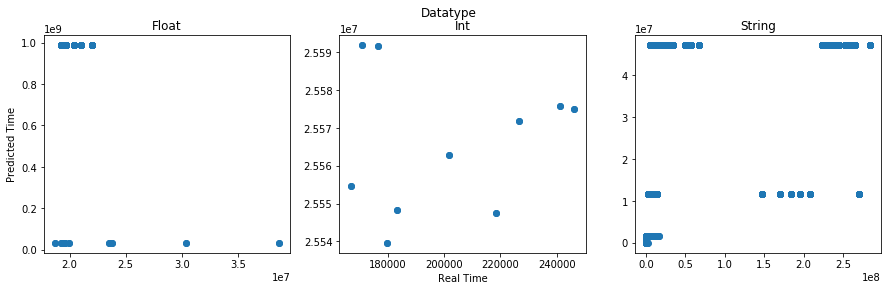

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Datatype')

axs[0].scatter(float_real_y, float_pred_y)
axs[0].set_title('Float')
axs[1].scatter(int_real_y, int_pred_y)
axs[1].set_title('Int')
axs[2].scatter(string_real_y, string_pred_y)
axs[2].set_title('String')

# for labels
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Real Time")
plt.ylabel("Predicted Time")
plt.show()